In [ ]:
!pip install ezdxf
!pip install tinygrad
!pip install matplotlib
!pip install scikit-learn
!pip install loguru
!pip install colorama
!pip install tqdm
!pip install plotly
!pip install ipywidgets
!pip install scipy


## Stat Overview

In [ ]:
!uptime

In [ ]:
!lscpu

In [ ]:
!nvidia-smi

In [ ]:
!nvcc --version

In [ ]:
!free -h

In [ ]:
!df -h

In [ ]:
from tinygrad import Device
print(Device.DEFAULT)

## Util

In [42]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import ezdxf


# DXF export function
def export_loss_to_dxf(loss_values, filename="loss_curve.dxf"):
    doc = ezdxf.new(dxfversion='R2010')
    msp = doc.modelspace()
    scale = 10
    for i, loss in enumerate(loss_values[:-1]):
        msp.add_line((i * scale, loss_values[i] * scale), ((i + 1) * scale, loss_values[i + 1] * scale))
    doc.saveas(filename)
    print(f"Loss curve exported as {filename}")


## Attention Head

In [43]:
from tinygrad import Tensor
import tinygrad as tngrd

class AttentionHead:
    def __init__(self, embed_dim, head_dim, requires_grad=True, dtype=tngrd.dtypes.float16):
        # Set dtype
        self.dtype = dtype

        # Initialize weights as Tensors with the specified dtype
        self.W_q = Tensor.randn(embed_dim, head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.W_k = Tensor.randn(embed_dim, head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.W_v = Tensor.randn(embed_dim, head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.W_o = Tensor.randn(head_dim, embed_dim, dtype=self.dtype, requires_grad=requires_grad)

        # Initialize biases
        self.b_q = Tensor.zeros(head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.b_k = Tensor.zeros(head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.b_v = Tensor.zeros(head_dim, dtype=self.dtype, requires_grad=requires_grad)
        self.b_o = Tensor.zeros(embed_dim, dtype=self.dtype, requires_grad=requires_grad)

        # Precompute the scale factor as a constant tensor
        self.scale_factor = Tensor((head_dim ** 0.5), dtype=self.dtype, requires_grad=False)

    def __call__(self, x):
        # Linear transformation for Q, K, V
        Q = x @ self.W_q + self.b_q
        K = x @ self.W_k + self.b_k
        V = x @ self.W_v + self.b_v

        # Dot product attention (QK^T)
        scores = Q @ K.transpose(2, 1)
        scaled_scores = scores / self.scale_factor
        attention_weights = scaled_scores.softmax(-1)

        # Attention output (Weighted sum of V)
        attention_output = attention_weights @ V

        # Final linear transformation
        output = attention_output @ self.W_o + self.b_o
        return output


### Tests

In [ ]:
import unittest
from tinygrad.nn.optim import SGD
import tinygrad as tngrd

class TestAttentionHead(unittest.TestCase):

    def setUp(self):
        self.embed_dim = 16
        self.head_dim = 8
        self.batch_size = 2
        self.seq_length = 4
        self.attention_head = AttentionHead(self.embed_dim, self.head_dim, requires_grad=True, dtype=tngrd.dtypes.float16)

    def test_linear_projection_shapes(self):
        x = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32))
        output = self.attention_head(x)
        self.assertEqual(output.shape, (self.batch_size, self.seq_length, self.embed_dim))

    def test_forward_pass(self):
        x = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32))
        output = self.attention_head(x)
        self.assertIsNotNone(output)
        self.assertEqual(output.shape, (self.batch_size, self.seq_length, self.embed_dim))

    def test_gradient_check(self):
        x = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32), requires_grad=True)
        output = self.attention_head(x)
        target = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32))
        loss = ((output - target) ** 2).mean()
        loss.backward()

        self.assertIsNotNone(x.grad)
        self.assertEqual(self.attention_head.W_q.grad.shape, self.attention_head.W_q.shape)

    def test_training(self):
        # Enable training mode
        Tensor.training = True  # Make sure Tensor.training is enabled for the optimizer

        # Test training over multiple iterations with gradient descent
        optimizer = SGD([self.attention_head.W_q, self.attention_head.W_k, self.attention_head.W_v, self.attention_head.W_o,
                        self.attention_head.b_q, self.attention_head.b_k, self.attention_head.b_v, self.attention_head.b_o], lr=0.01)

        loss_values = []  # Track loss values for plotting

        for _ in range(200):
            x = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32), requires_grad=True)
            target = Tensor(np.random.randn(self.batch_size, self.seq_length, self.embed_dim).astype(np.float32))
            output = self.attention_head(x)
            loss = ((output - target) ** 2).mean()
            loss_values.append(loss.numpy())  # Store the loss value

            print("Loss:", repr(loss.numpy()))

            # Backward pass to compute gradients
            loss.backward()

            # Perform optimization step
            optimizer.step()

            # Zero the gradients for the next step
            optimizer.zero_grad()

            # Assert that loss is a scalar
            self.assertEqual(loss.shape, ())

        # After training, export the loss values to DXF
        export_loss_to_dxf(loss_values, filename="loss_curve.dxf")

        # Disable training mode after test
        Tensor.training = False  # Reset training mode after test

# Run the tests
unittest.main(argv=[''], verbosity=2, exit=False)

### Analysis

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50


2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28:12.952 | INFO     | __main__:<module>:86 - Training model 50/50

2024-10-07 13:28


Training Steps:  98%|█████████▊| 977/1000 [00:03<00:00, 269.26it/s]
                                                                   2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625


2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | INFO     | __main__:<module>:93 - Model 50 finished with final loss: 1.009765625

2024-10-07 13:28:17.836 | IN

Training Models: 100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


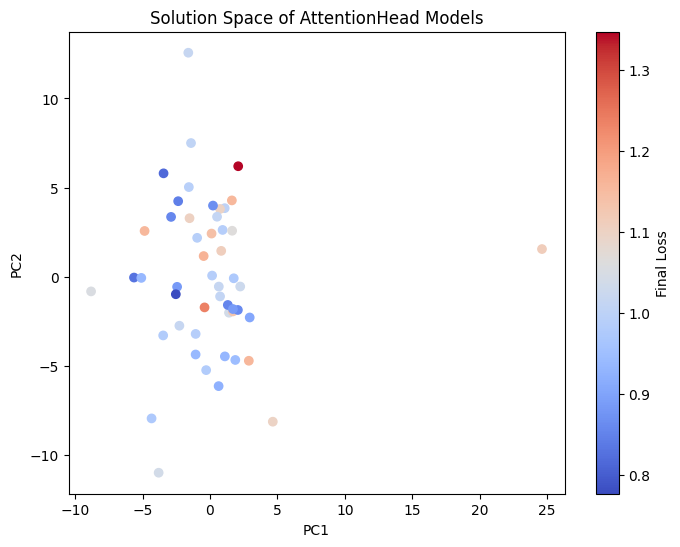

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!


2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot generated!

2024-10-07 13:28:18.915 | INFO     | __main__:<module>:116 - Training completed and plot ge

In [64]:
import os  # For clearing the terminal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tinygrad.nn.optim import SGD
from tqdm import tqdm  # For progress bars
from loguru import logger  # For logging
from colorama import Fore, Style  # For colored terminal output
from IPython.display import clear_output
from tinygrad import TinyJit
from tinygrad.helpers import Context
import tinygrad

# Initialize Colorama for colored text
from colorama import init
init(autoreset=True)

# Customize logger with colored output using colorama
logger.add(lambda msg: print(f"{Fore.GREEN}{msg}{Style.RESET_ALL}"))

# Training function for attention head
def train_attention_head(attention_head, num_iterations=1000, lr=0.01):

    # Enable training mode
    # Tensor.training = True  # Make sure Tensor.training is enabled for the optimizer

    @TinyJit
    @Tensor.train()
    def train_step(model, x, target, optimizer):
        optimizer.zero_grad()

        output = model(x)
        loss = ((output - target) ** 2).mean()

        loss.backward()
        optimizer.step()
        return loss.realize()

    optimizer = SGD([attention_head.W_q, attention_head.W_k, attention_head.W_v, attention_head.W_o,
                     attention_head.b_q, attention_head.b_k, attention_head.b_v, attention_head.b_o], lr=lr)

    # loss_values = []
    for _ in tqdm(range(num_iterations), desc="Training Steps", leave=False):
        x = Tensor.randn(batch_size, seq_length, embed_dim, dtype=tinygrad.dtypes.float16, requires_grad=True)
        target = Tensor.randn(batch_size, seq_length, embed_dim, dtype=tinygrad.dtypes.float16)
        loss = train_step(attention_head, x, target, optimizer)
        # loss_values.append(loss.numpy())

    # Return final loss and concatenation of all weights
    final_loss = loss.numpy()
    weights_vector = np.concatenate([attention_head.W_q.numpy().flatten(),
                                     attention_head.W_k.numpy().flatten(),
                                     attention_head.W_v.numpy().flatten(),
                                     attention_head.W_o.numpy().flatten(),
                                     attention_head.b_q.numpy(),
                                     attention_head.b_k.numpy(),
                                     attention_head.b_v.numpy(),
                                     attention_head.b_o.numpy()])

    # Disable training mode
    # Tensor.training = False  # Reset training mode

    return final_loss, weights_vector

# Hyperparameters
num_models = 50
embed_dim = 16
head_dim = 8
batch_size = 2
seq_length = 4

# Train multiple AttentionHead models and collect weight vectors and losses
weight_vectors = []
losses = []

logger.info(f"Starting training of {num_models} models")

with Context(DEBUG=0): # BEAM=2
    # Outer tqdm loop for training multiple models
    for i in tqdm(range(num_models), desc="Training Models"):
        clear_output(wait=True)
        # Clear the terminal before logging each model's details
        os.system('cls' if os.name == 'nt' else 'clear')

        logger.info(f"{Fore.CYAN}Training model {i+1}/{num_models}{Style.RESET_ALL}")
        attention_head = AttentionHead(embed_dim, head_dim, requires_grad=True, dtype=tngrd.dtypes.float16)

        final_loss, weights_vector = train_attention_head(attention_head)
        weight_vectors.append(weights_vector)
        losses.append(final_loss)

        logger.info(f"Model {i+1} finished with final loss: {Fore.YELLOW}{final_loss}{Style.RESET_ALL}")

# Convert to numpy arrays for dimensionality reduction
weight_vectors = np.array(weight_vectors)
losses = np.array(losses)

# Standardize the weight vectors
scaler = StandardScaler()
weight_vectors_std = scaler.fit_transform(weight_vectors)

# Apply PCA (or TSNE or UMAP) for dimensionality reduction
pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(weight_vectors_std)

# Create a 2D heatmap (or 3D plot with loss values)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=losses, cmap='coolwarm')
plt.colorbar(label='Final Loss')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Solution Space of AttentionHead Models')
plt.show()

logger.info(f"{Fore.GREEN}Training completed and plot generated!{Style.RESET_ALL}")
